In [1]:
%load_ext autoreload
%autoreload 2

In [494]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy import cosmology
from astropy import constants as co
from astropy import table
from astropy import units as u
from astropy.io import fits
from astropy import coordinates

from ekfphys import observer
from ekfplot import plot as ek
from ekfplot import colors as ec
from ekfstats import functions, sampling

from agrias import utils

import reader 

cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [3]:
import sys
sys.path.append('/Users/kadofong/work/projects/SAGAbg/scripts/')
import catalogs, do_directhalphaphotometry

In [4]:
cd ~/work/projects/SAGAbg/scripts/

/Users/kadofong/work/projects/SAGAbg/scripts


In [5]:
asb, logmstar = catalogs.load_singleton_catalog('ASB')

SAGA `shared_dir` set to /Users/kadofong/DropBox/SAGA/
SAGA `local_dir`  set to ../local_data/


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/SAGA/utils/functions.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table[c][mask] = v
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/SAGA/utils/functions.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table[c][mask] = v
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/SAGA/utils/functions.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [6]:
cd ~/work/projects/merian/agrias/notebooks

/Users/kadofong/work/projects/merian/agrias/notebooks


In [454]:
saga_lha_df = pd.read_csv('/Users/kadofong/Desktop/saga_lha.csv', index_col=0)

saga_dust = pd.read_csv('/Users/kadofong/Desktop/SAGAbgA_dust.csv', index_col=0)

In [453]:
merian_lha_df = pd.read_csv ( '/Users/kadofong/Desktop/merian_catalog_halum.csv', index_col=0)
merian_lha_df = pd.read_csv('../local_data/output/lha_df.csv', index_col=0)
merian_lha_df = merian_lha_df.reindex(merian_sources.index)

In [603]:
merian_sources = reader.merianselect ()

[merianselect] Only choosing sources at 0.070<z_phot<0.090
[merianselect] Only choosing sources with i_cModelmag_Merian < 22.0
[merianselect] only choosing sources with cmodel/gaap(i) > 1.3


In [512]:
gama = table.Table(fits.open('/Users/kadofong/work/projects/gama/local_data/SersicCatSDSSv09.fits')[1].data).to_pandas()
gama = gama.set_index("CATAID")

gama_spec = table.Table(fits.open('/Users/kadofong/work/projects/gama/local_data/GaussFitComplexv05.fits')[1].data)
gama_spec = gama_spec.to_pandas().set_index("CATAID")

gama_specobj = table.Table(fits.open('/Users/kadofong/work/projects/gama/local_data/SpecObjv27.fits')[1].data)
gama_specobj = gama_specobj.to_pandas().set_index("CATAID")
gama_specobj = gama_specobj.query("NQ>=4")
inband = (gama_specobj['Z']>0.05)&(gama_specobj['Z']<0.1)
gama_specobj = gama_specobj.loc[inband]

overlap = gama.index.intersection(gama_spec.index).intersection(gama_specobj.index)

gama = gama.reindex(overlap)
gama_spec = gama_spec.loc[~gama_spec.index.duplicated()].reindex(overlap)
gama_specobj = gama_specobj.loc[~gama_specobj.index.duplicated()].reindex(overlap)
print(f"{len(overlap)} relevant GAMA sources at 0.05<z<0.1")

gr = gama['GALMAG_g'] - gama['GALMAG_r']
gama['gr'] = gr
kcorr = observer.photometric_kcorrection(gr, gama_specobj['Z'] )
kcorr[abs(gr)>3] = np.NaN

gama['Mr'] = gama['GALMAG_r'] - cosmo.distmod(gama_specobj['Z'].values).value - kcorr

ew_c = 2.5
bd_intrinsic = 2.86

lum_r = 10.**(-0.4*(gama['Mr']-34.1)) 
ew = gama_spec['HA_EW']+ew_c
hbsnr = gama_spec['HB_FLUX']/gama_spec['HB_FLUX_ERR']
bd_gama = (gama_spec['HA_EW']+ew_c)/gama_spec['HA_EW'] * gama_spec['HA_FLUX']
bd_gama /= (gama_spec['HB_EW']+ew_c)/gama_spec['HB_EW'] * gama_spec['HB_FLUX']

# \\ replace BD < 2.86 values with AV drawn from uncertainty
np_samp = bd_gama[bd_gama<bd_intrinsic]
np_samp_rev = 2.*bd_intrinsic - np_samp 
np_samp = np.concatenate([np_samp, np_samp_rev])
bd_np = np.random.normal( bd_intrinsic, sampling.sigmaclipped_std(np_samp), np_samp_rev.size*10 )
bd_np = bd_np[bd_np>bd_intrinsic]
bd_gama.loc[bd_gama<bd_intrinsic] = bd_np[:int(sum(bd_gama<bd_intrinsic))]
#bd_gama.loc[hbsnr<5.] = np.NaN

dust = (bd_gama/bd_intrinsic)**2.36
dust.loc[hbsnr<=5.] = np.NaN
gama['LHa'] = ew * lum_r * 3e18 / (6564.6*(1.+gama_specobj['Z']))**2. * dust * 1e7


#gama.loc[hbsnr<5.,'LHa']=np.NaN

16012 relevant GAMA sources at 0.05<z<0.1


/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_25458/1182006390.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[4.55427058 3.52205692 2.99168509 ... 5.97734378 3.7380049  4.76050946]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  bd_gama.loc[bd_gama<bd_intrinsic] = bd_np[:int(sum(bd_gama<bd_intrinsic))]


In [520]:
u_bd_gama = np.sqrt( (gama_spec['HA_FLUX_ERR']/gama_spec['HB_FLUX'])**2 + (bd_gama/gama_spec['HB_FLUX']*gama_spec['HA_FLUX_ERR'])**2 )

(0.0, 10.0)

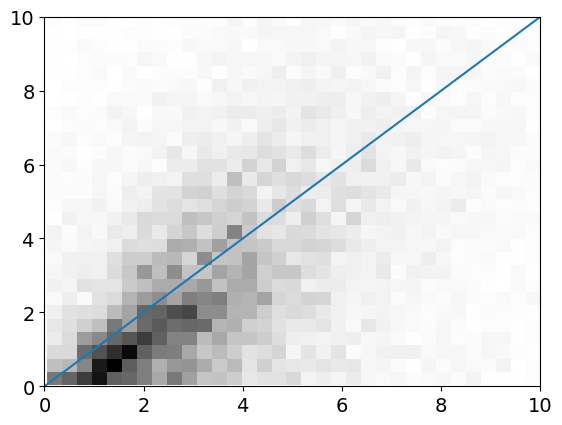

In [528]:
_=ek.hist2d(
    hbsnr,
    bd_gama/u_bd_gama,
    bins=100
)
xs = np.linspace(0.,10.,100)
plt.plot(xs,xs)
plt.xlim(0,10)
plt.ylim(0,10)

In [620]:
#saga = np.genfromtxt('/Users/kadofong/Desktop/ref.txt')
saga_coords = coordinates.SkyCoord(asb['RA'],asb['DEC'],unit='deg')

In [621]:
gama_coords = coordinates.SkyCoord(gama['RA'],gama['DEC'],unit='deg')

In [622]:
merian_coords = coordinates.SkyCoord(merian_sources['RA'],merian_sources['DEC'],unit='deg')

In [633]:
idx,d2d,_= merian_coords.match_to_catalog_sky(gama_coords)
is_match = d2d < (2. * u.arcsec)

In [634]:
idx_saga, d2d_saga, _ = saga_coords.match_to_catalog_sky(gama_coords)
is_match_saga = d2d_saga <  (2.*u.arcsec)

In [635]:
idx_sm, d2d_sm, _ = merian_coords.match_to_catalog_sky(saga_coords)
is_match_sm = d2d_sm < (2.*u.arcsec)

In [636]:
emission_correction, ge_arr, extinction_correction = do_directhalphaphotometry.observational_corrections(merian_sources)

In [637]:
dlum = cosmo.luminosity_distance(merian_sources['z_phot'].values).to(u.cm).value
merian_lha_df['FHa'] = merian_lha_df['LHa']*1e40 / (4.*np.pi*dlum**2)

fc = 0.5*(merian_sources['r_gaap1p0FluxErr_aperCorr_Merian'] + merian_sources['i_gaap1p0Flux_aperCorr_Merian'])
fc *= apercorr
fc = fc * (u.nJy * co.c/(6563.*(1.+merian_sources['z_phot'].values)*u.AA)**2).to(u.erg/u.s/u.cm**2/u.AA)
uncorrected_fha = merian_lha_df['FHa'] / ge_arr[:,2] / extinction_correction[:,2]
merian_lha_df['EW'] = uncorrected_fha / fc

In [638]:
def lee_aha(Mb):
    aha = np.zeros_like(Mb)
    aha = np.where(Mb < -14.5, 1.971 + 0.323 * Mb + 0.0134 * Mb**2, 0.1)
    return aha

In [639]:
lee_av = observer.alambda_to_av(lee_aha(merian_sources['Mg'] ),6563.)

Text(0, 0.5, '$A_V$')

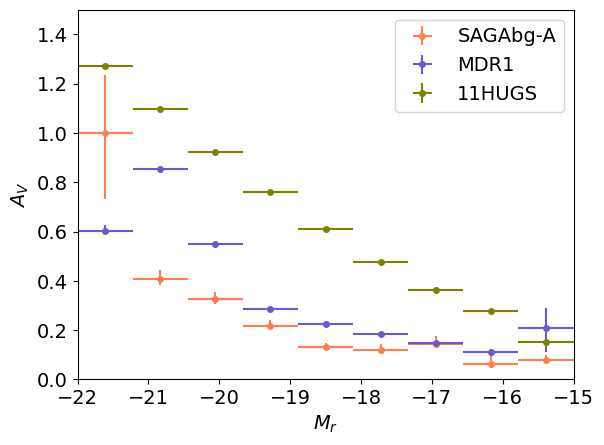

In [640]:
labels = ['GAMA','SAGAbg-A','MDR1', '11HUGS',]
avs = [ observer.balmerdecrement_to_av(bd_gama), saga_dust['AV'], merian_sources['AV'], lee_av ]
mrs = [ gama['Mr'], saga_dust['Mr'], merian_sources['Mr'], merian_sources['Mr'] ]
#mrs = [ None, saga_dust["logmstar"], merian_sources['logmass_gaap1p0'] + np.log10(apercorr) ]
#mrs = [ gama['gr'], saga_dust['gr'], -2.5*np.log10(merian_sources[utils.photcols['g']]/merian_sources[utils.photcols['r']]) ]
cs_hexcodes = ["#008080", "#FF7F50", "#6A5ACD", "#808000"]

cbases = [ ec.ColorBase(cs) for cs in cs_hexcodes ]

bins = np.linspace(-22., -15., 10)
#bins = np.linspace(6,11.,20)
#bins = np.linspace(-0.75,1.,20)
for axindex in range(1,len(labels)):
    #_=ek.density_contour(
    #    mrs[idx],
    #    avs[idx],
    #    cmap=cbases[idx].sequential_cmap(),
    #    label=labels[idx]
    #)
    out=ek.running_quantile(
        mrs[axindex],
        avs[axindex],
        bins=bins,
        color=cbases[axindex].base,
        erronqt=True,
        show_std=False,
        label=labels[axindex]
    )
    if axindex == 1:
        xbins,ystats = out

plt.legend ()
plt.ylim(0.,1.5)
plt.xlim(bins.min(), bins.max())
plt.xlabel(r'$M_r$')
plt.ylabel(r'$A_V$')

-0.015111350519959932

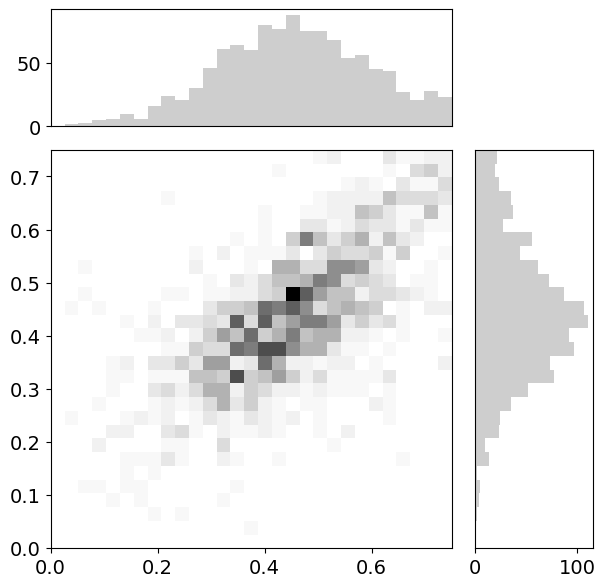

In [641]:
gama_mag = gama.iloc[idx[is_match]]['GALMAG_g'].values - gama.iloc[idx[is_match]]['GALMAG_r'].values
merian_mag = -2.5*np.log10(merian_sources.loc[is_match, utils.photcols['g']]/merian_sources.loc[is_match, utils.photcols['r']])
gama_mag, merian_mag = functions.finite_masker([gama_mag,merian_mag], inplace=True, ul=10, ll=-10.)

out, axarr=ek.hist2d(
    gama_mag,
    merian_mag,
    bins=[np.linspace(0.,0.75,30),np.linspace(0.,0.75,30)],
    show_proj=True
)
np.nanmedian(merian_mag-gama_mag)

[Text(0, 0.1, ''),
 Text(0, 1.0, ''),
 Text(0, 10.0, ''),
 Text(0, 100.0, ''),
 Text(0, 1000.0, ''),
 Text(0, 10000.0, '')]

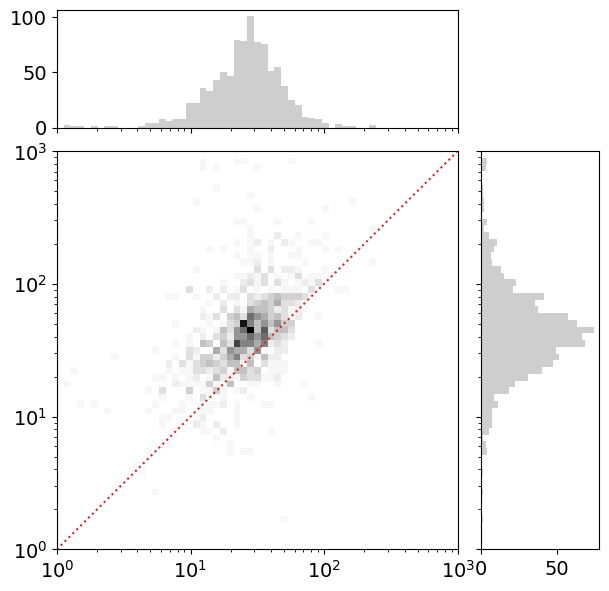

In [645]:
gama_lha = gama_spec.iloc[idx[is_match]]['HA_EW'].values
merian_lha = merian_lha_df.loc[is_match, 'EW'] #* 1e40
gama_lha, merian_lha = functions.finite_masker([gama_lha,merian_lha], inplace=True, )#ll=1e20, ul=1e50)
bins = np.logspace(0., 3.,60)
out, axarr=ek.hist2d(
    gama_lha,
    merian_lha,
    bins=[bins,]*2,
    show_proj=True,
)
axarr[0].plot(bins,bins, color='tab:red', ls=':')
ek.loglog(axarr[0])
axarr[1].set_xscale('log')
axarr[2].set_yscale('log')
axarr[1].set_xticklabels('')
axarr[2].set_yticklabels('')

#np.nanmedian(merian_mag-gama_mag)

Text(0, 0.5, 'g-r (SAGA)')

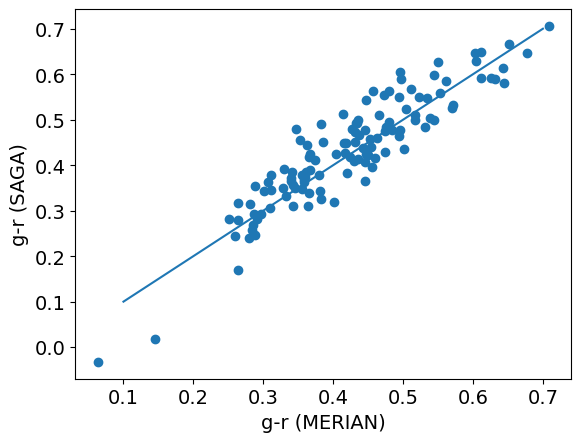

In [18]:
xf = asb.reindex(asb.index[idx_sm[is_match_sm]])
saga_mag = xf['g_mag'] -  xf['r_mag']
saga_mag = saga_mag.values
merian_mag = -2.5*np.log10(merian_sources.loc[is_match_sm, utils.photcols['g']]/merian_sources.loc[is_match_sm, utils.photcols['r']])
saga_mag, merian_mag = functions.finite_masker([saga_mag,merian_mag], inplace=True, ul=10., ll=-10.)

plt.scatter(
    saga_mag,
    merian_mag,
)
xs = [0.1,0.7]
plt.plot(xs,xs)
np.nanmedian(merian_mag-saga_mag)
plt.xlabel('g-r (MERIAN)')
plt.ylabel('g-r (SAGA)')

0.0977750389475503


Text(0, 0.5, 'r-z (SAGA)')

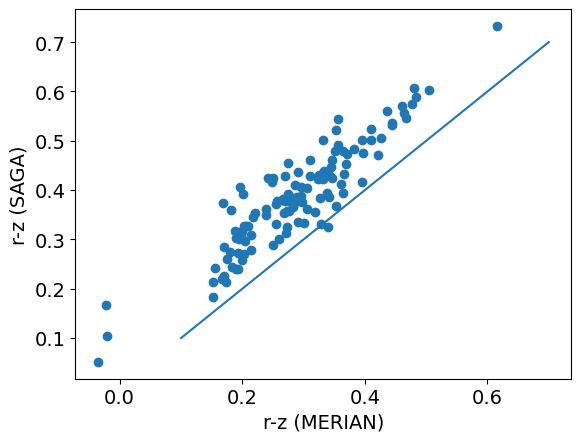

In [19]:
saga_mag = (xf['r_mag'] -  xf['z_mag']).values
merian_mag = -2.5*np.log10(merian_sources.loc[is_match_sm, utils.photcols['r']]/merian_sources.loc[is_match_sm, utils.photcols['z']])
saga_mag, merian_mag = functions.finite_masker([saga_mag,merian_mag], inplace=True, ul=10., ll=-10.)

plt.scatter(
    saga_mag,
    merian_mag,
)
xs = [0.1,0.7]
plt.plot(xs,xs)
print(np.nanmedian(merian_mag-saga_mag))
plt.xlabel('r-z (MERIAN)')
plt.ylabel('r-z (SAGA)')

0.023400699278385062


Text(0, 0.5, 'm$_z$ (SAGA)')

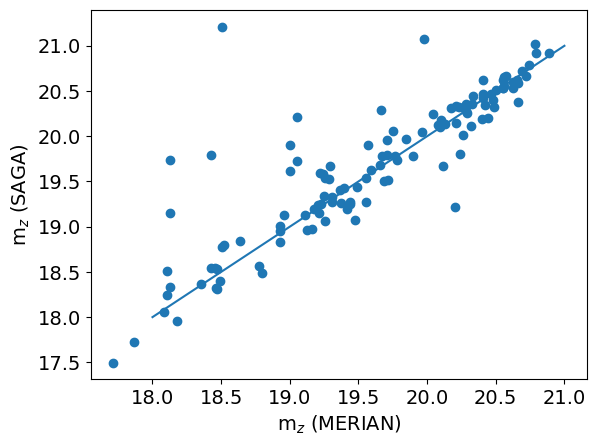

In [20]:
band = 'r'
saga_mag = xf[f'{band}_mag'].values

apercorr = merian_sources['i_cModelFlux_Merian']/merian_sources['i_gaap1p0Flux_Merian']
flux = merian_sources.loc[:,utils.photcols[band]]*apercorr

merian_mag = -2.5*np.log10(flux.loc[is_match_sm]) + 31.4
saga_mag, merian_mag = functions.finite_masker([saga_mag,merian_mag], inplace=True, ul=30,ll=3.)

plt.scatter(
    saga_mag,
    merian_mag,
)
#xs = [0.1,0.7]
xs = [18.,21.]
plt.plot(xs,xs)
print(np.nanmedian(merian_mag-saga_mag))
plt.xlabel(r'm$_z$ (MERIAN)')
plt.ylabel(r'm$_z$ (SAGA)')

In [21]:
saga_halum = saga_lha_df.reindex(asb.index[idx_sm[is_match_sm]])['LHa_50']
#merian_halum = catalog_halum.loc[is_match_sm, 'LHa']

merian_halum = merian_lha_df.loc[is_match_sm,'LHa']*1e40

wordid
brim_lucidly            NaN
targeting_venerable     NaN
bather_numbing          NaN
proforma_benchmarking   NaN
wasp_airs               NaN
                         ..
dominates_expediting    NaN
mercenaries_reset       NaN
sorcerers_pithiest      NaN
hostess_peroration      NaN
worriedly_slope         NaN
Name: LHa_50, Length: 120, dtype: float64

Text(0, 0.5, 'L(Ha) Merian catalog, corrected')

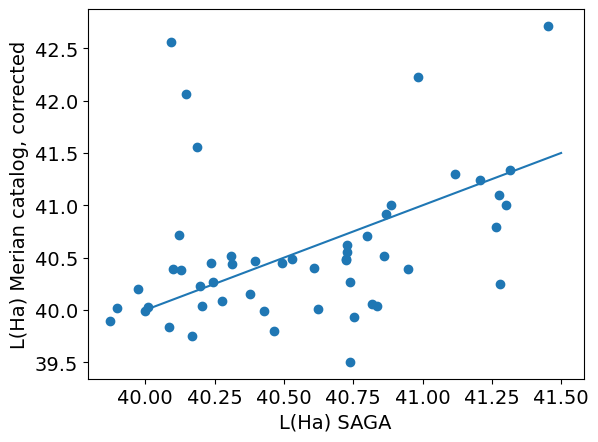

In [27]:
plt.scatter(
    np.log10(saga_halum),
    np.log10(merian_halum) 
)
xs = np.array([40.,41.5])
plt.plot(xs,xs)
plt.xlabel('L(Ha) SAGA')
plt.ylabel('L(Ha) Merian catalog, corrected')